<a href="https://colab.research.google.com/github/JackyYang27/Predict_the_author_using_CNN/blob/main/ARTCNN_prac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 作業 1 : 辨識名畫的作者

資料集: [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

程式碼參考自: [Tensorflow](https://www.tensorflow.org/)

> **資料集說明**

After being challenged many times by my girlfriend about who is the best to guess the painter, I decided to use the power of machine learning to defeat her.I gathered a collection of artworks of the 50 most influential artists of all time.

請幫幫資料集作者完成他女朋友的挑戰。**訓練一個 CNN 模型輸入是一張畫作，辨識出這張畫可能是哪個畫家的作品。**


>**作業說明**

**第一步驟**: 左上角 檔案 -> 在雲端硬碟建立副本。

**第二步驟**: 右上角 共用 -> 取得連結 -> 任何知道這個連結的人都能編輯

**第三步驟**: 左上角 執行階段 -> 更變執行類型 -> GPU。可以加快模型速度

**第四步驟**: 檔案名稱，請填寫你的學號，把副本上下引號刪掉

請 **隨意修改** 這個 colab 的程式來完成訓練 CNN 模型。**只要跑得出來 Testing Accuracy、Loss; 1~7 個作業項目即可**，不必一定要照著 todo 提示走。
繳交時記得改檔案標題的學號。

本次作業著重在前處理，現實中很多筆資料的 label 不見得會直接給你，很多都會在奇怪的位置，例如本次作業，label 隱藏在圖片名稱之中。你需要做很多前處理來提取標籤。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看 test data
2. 模型請手刻、手疊，**不要用 Transfer Learning** 來引入 ResNet、Inception...等知名模型來增加準確率。
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存 output 結果，更改**檔名學號**，左上角 檔案 -> 下載 -> 下載.ipynb檔。
2. 交一個 pdf 檔，裡面需要附上**你的作業 colab 連結(設為可編輯)**、姓名學號年級、過程和執行結果的截圖，並說明你程式撰寫的過程、本次作業心得(字數不限)。
3. 文件內至少應貼上你的 Test Acc
4. 上述兩個檔案繳交至 ee-class。

> **算分標準**

程式基本分（20%） + Test_Acc（50%） + Predict function（10%） + 文件（20%）
1. 20 分程式基本分
    - 未繳交視同０分！！！
    - 需完成作業第一至第六段
    - 每一步驟皆需有 output，且不得為 error code
2. Test_Acc (1 分/1%，超過 50% 以 50 分計)
3. predict_author 有寫出來沒 error 就 10 分（第七段）
4. 20 分文件分數
    - 姓名、學號、年級（1%）
    - colab 連結（1%）
    - Test accuracy（2%）
    - 撰寫過程與截圖（8%）
    - 心得（8%）


有問題再來信助教: 劉亞叡(grayt991014@gmail.com), 劉冠甫(kevin112423026@g.ncu.edu.tw)

### 資料集下載

- 資料集說明 :
  - artists.csv : dataset of information for each artist
  - train_resized/ : image dataset of training paintings. Image name contain image author's name.
  - test_resized/ : image dataset of testing paintings. Image name contain image author's name.
  - 詳細內容可以下載完點擊 colab 左側**檔案**來查看

- 下載連結：
  - train: https://drive.google.com/file/d/1K3FRVeabwV7TxboRsrkFcT34tPV9DWqr/view?usp=sharing
  - test: https://drive.google.com/file/d/1GCzWxFrIbb4d1JSXSrt3kRb6uERVqXpx/view?usp=sharing


In [131]:
import random
import os

# 大家盡量先把資料保存在本地端，然後要訓練時用本地端上傳做訓練
# 以節省學術網路資源，避免 IP 被封鎖

if not os.path.isfile("./train.zip"):
    !wget -O train.zip "http://140.115.83.111/files/art/train.zip"
    !wget -O test.zip "http://140.115.83.111/files/art/test.zip"
    !unzip train.zip
    !unzip test.zip
else:
    !echo "檔案已存在"

檔案已存在


## 1. 讀入封包

In [132]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import math

## 2. 取得資料集

- **我們來檢視一下 artist.csv**，重要內容包含:
  - 畫家名稱 (name)
  - 風格 (genre)
  - 資料集內畫作數量 (paintings)

總共有 50 位畫家，意謂著有 50 個 class 要去辨識。

In [133]:
train_dir = "./train_resized/"
test_dir = "./test_resized/"
artists = pd.read_csv("./artists.csv")
num_classes = artists.shape[0]
print("Number of artists : ", num_classes)
artists.head()

Number of artists :  50


id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: ?а?и?...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod m?n?]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [??ne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

* 只取出名字與畫的數量，把名字用下底線連起來

In [134]:
artists = artists.loc[:, ["name", "paintings"]]
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
artists.head()

name  paintings
0   Amedeo_Modigliani        193
1  Vasiliy_Kandinskiy         88
2        Diego_Rivera         70
3        Claude_Monet         73
4       Rene_Magritte        194

* **計算各個畫家畫作數量**
* 每個 class 資料的不平衡容易影響模型的訓練，學生可以嘗試解決這個問題。(提示: keras 的 class_weight)

可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。
最多畫作為 :  877  最少畫作為 :  24


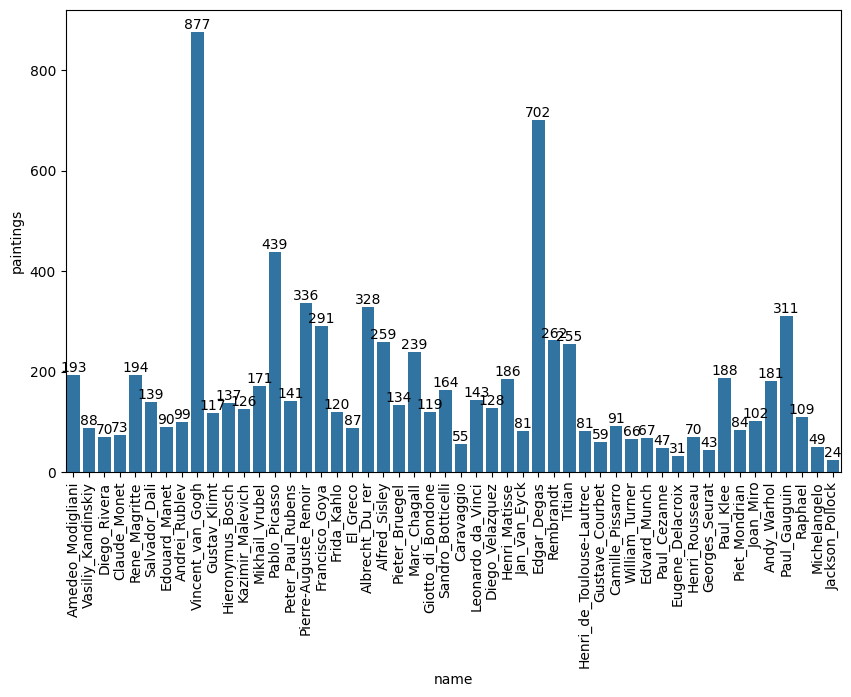

In [135]:
%matplotlib inline
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=artists.name, y=artists.paintings)
for index, value in enumerate(artists.paintings):
    barplot.text(index, value, str(value), color='black', ha="center", va='bottom')
for item in barplot.get_xticklabels():
    item.set_rotation(90)

print("可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。")
print("最多畫作為 : ", artists.paintings.max(), " 最少畫作為 : ", artists.paintings.min())

* 隨機讀取畫作來看看

training 畫作總共畫作有 :  7520


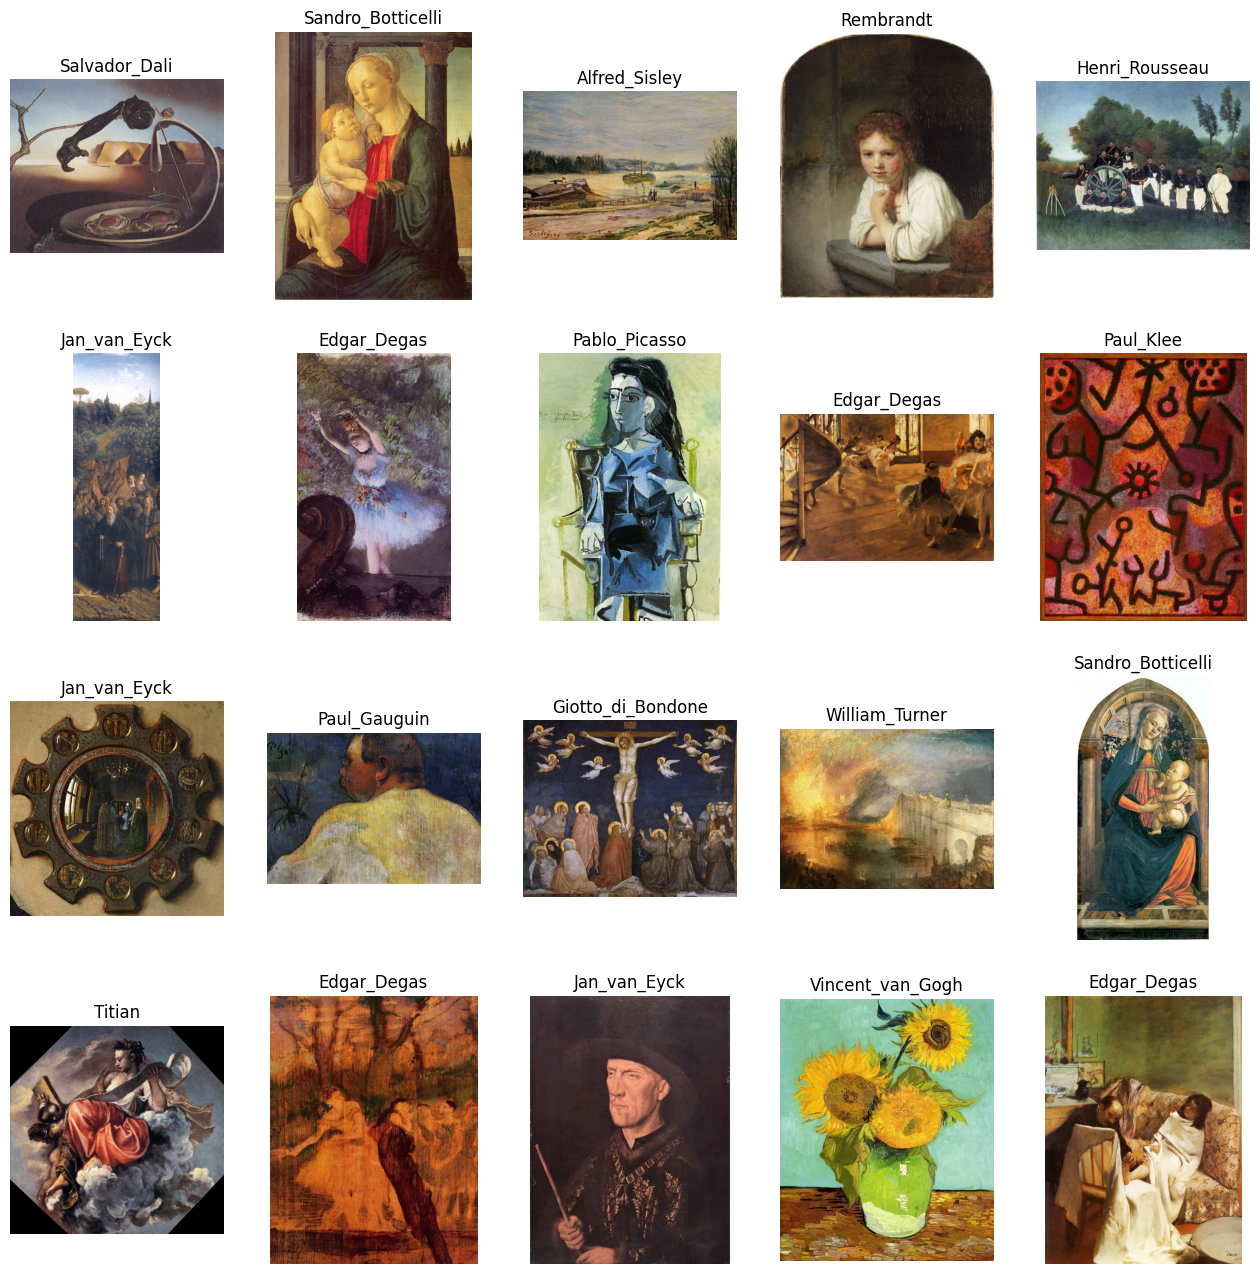

In [136]:
img_list = os.listdir(train_dir)
total_len = len(img_list)
random_list = random.sample(range(0, total_len), 20)
print("training 畫作總共畫作有 : ", total_len)

show_imgs = [img_list[rand] for rand in random_list]

plt.figure(figsize=(16, 16))
for index, imgName in enumerate(show_imgs):
    imgpath = train_dir + imgName
    img = cv.imread(imgpath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(4, 5, index + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1]))

## 3. 資料前處理

**有幾個重要的點需要處理**
1. 我們現在只有各個畫的路徑。Ex: /content/train_resized/Claude_Monet_22.jpg 。要取出 label : Claude_Monet
2. label (作者名稱)是英文，我們要先把英文映射成數字。EX: Van_Gogh --> 0 ; Edvard_Munch --> 1
3. label 數字還要轉成 50 depth 的 one_hot
4. 現在有畫的路徑了，要讀取圖片
5. 每張圖片的大小不一樣，要統一大小才能輸入模型
6. 把每張圖片正規化，映射到 [0,1] 之間
7. 路徑是按照作者名稱排列的，太整齊了，把資料集打散(shuffle)。
8. 如果有需要，拆分成訓練用資料(training_data)、驗證用(validation_data)
9. **重要!** 確定好你資料 input output 的維度，才能開始建立模型。EX: input:(256,256,3); output:(50,)

**助教推薦一個好用的工具** from_tensor_slices [參考](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

* from_tensor_slices 可以輕鬆的讀取想要的資料，把圖片路徑傳入 tensor 後用 map 將路徑轉成圖片檔案。

* **以下程式 todo 只是提供程式思路，你完全可以不理他，反正 test 結果能出來就好。**

In [137]:
# 請建立將英文映射成數字的 dict。EX: Van_Gogh --> 0
def make_author_dict():
    authors = ['_'.join(name.split('_')[:-1]) for name in os.listdir(train_dir) if name.endswith('.jpg')]
    unique_authors = list(set(authors))
    author_to_id = {author: id for id, author in enumerate(unique_authors)}
    return author_to_id

class_name = make_author_dict()
print(class_name)
# 請建立將數字映射成英文的 dict。 EX: 0 --> Van_Gogh
rev_class_name = {v: k for k, v in class_name.items()}
print(rev_class_name)

{'Rene_Magritte': 0, 'Kazimir_Malevich': 1, 'Edouard_Manet': 2, 'Leonardo_da_Vinci': 3, 'Raphael': 4, 'Diego_Velazquez': 5, 'Marc_Chagall': 6, 'Peter_Paul_Rubens': 7, 'Paul_Klee': 8, 'Giotto_di_Bondone': 9, 'Henri_de_Toulouse-Lautrec': 10, 'Amedeo_Modigliani': 11, 'Alfred_Sisley': 12, 'El_Greco': 13, 'Henri_Matisse': 14, 'Sandro_Botticelli': 15, 'Titian': 16, 'Andrei_Rublev': 17, 'Claude_Monet': 18, 'Piet_Mondrian': 19, 'Salvador_Dali': 20, 'Gustave_Courbet': 21, 'Paul_Gauguin': 22, 'Pieter_Bruegel': 23, 'Vincent_van_Gogh': 24, 'Joan_Miro': 25, 'Gustav_Klimt': 26, 'Henri_Rousseau': 27, 'Mikhail_Vrubel': 28, 'Caravaggio': 29, 'Pierre-Auguste_Renoir': 30, 'Jan_van_Eyck': 31, 'Eugene_Delacroix': 32, 'Camille_Pissarro': 33, 'Hieronymus_Bosch': 34, 'Paul_Cezanne': 35, 'Albrecht_Du_rer': 36, 'Jackson_Pollock': 37, 'Pablo_Picasso': 38, 'Francisco_Goya': 39, 'Frida_Kahlo': 40, 'Georges_Seurat': 41, 'Vasiliy_Kandinskiy': 42, 'Diego_Rivera': 43, 'Rembrandt': 44, 'Andy_Warhol': 45, 'Edvard_Munch'

In [138]:

def get_label(picName):
    # 請取出 label 並轉成數字
    # EX: Claude_Monet_1.jpg -> Claude_Monet -> 1
    author = '_'.join(picName.split('_')[:-1])
    return class_name[author]

def get_path(dir, picName):
    # 請將路徑合併
    # EX: ./train_resized/ + Claude_Monet_1.jpg => ./train_resized/Claude_Monet_1.jpg
    path = dir+picName
    return path


def make_paths_label(dir):
    img_list = os.listdir(dir)
    paths = []
    labels = []

    # 將preprocess完成的 path、label 用 for 迴圈放入 paths 和 labels
    for img_name in img_list:
        path = get_path(dir, img_name)
        label = get_label(img_name)
        paths.append(path)
        labels.append(label)

    # 將 labels 轉成 onehot
    onehot_labels = tf.keras.utils.to_categorical(labels, num_classes=len(class_name))
    return paths, onehot_labels

# 使用 tf.data 來載入數據
def load_data(paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    img_label_ds = path_ds.map(lambda x: tf.py_function(process_path, [x], [tf.float32, tf.int32]),
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return img_label_ds

paths, onehot_labels = make_paths_label(train_dir)


In [139]:
# 來查看一下
paths, onehot_labels = make_paths_label(train_dir)
print("paths : ")
for p in paths[:5]:
    print(p)
print("-" * 20)
print("labels : ")
for label in onehot_labels[:5]:
    print(label)

paths : 
./train_resized/Raphael_17.jpg
./train_resized/Albrecht_Du_rer_120.jpg
./train_resized/Edgar_Degas_259.jpg
./train_resized/El_Greco_57.jpg
./train_resized/Pierre-Auguste_Renoir_323.jpg
--------------------
labels : 
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


* 目標輸出

![](https://i.imgur.com/CSzFlZ2.png)

In [140]:
# 決定你輸入模型的圖片長寬
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
# shuffle buffer size
SHUFFLE_BUFFER = 6000


def get_image(path):
    # read image from path
    file = tf.io.read_file(path)
    img = tf.io.decode_jpeg(file, channels=3)

    # 請固定每張圖片大小為 IMG_HEIGHT、IMG_WIDTH
    # 並將圖片每個 pixel 映射到 [0,1] 之間
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0
    return img


# 將所有資料轉成 Tensor -> Tensor 轉成圖片
# 圖片 Tensor 與 label Tensor Zip 起來成一個 pair
# shuffle 打散
def make_dataset(dir):
    paths, onehot_labels = make_paths_label(dir)
    paths_ds = tf.data.Dataset.from_tensor_slices(paths)
    train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)
    # 將路徑 tensor 映射成圖片 tensor
    train_image = paths_ds.map(get_image)
    # 合併圖片與 label 資料集
    full_ds = tf.data.Dataset.zip((train_image, train_label))
    # 打散
    full_ds = full_ds.shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=False)
    return full_ds


full_ds = make_dataset(train_dir)

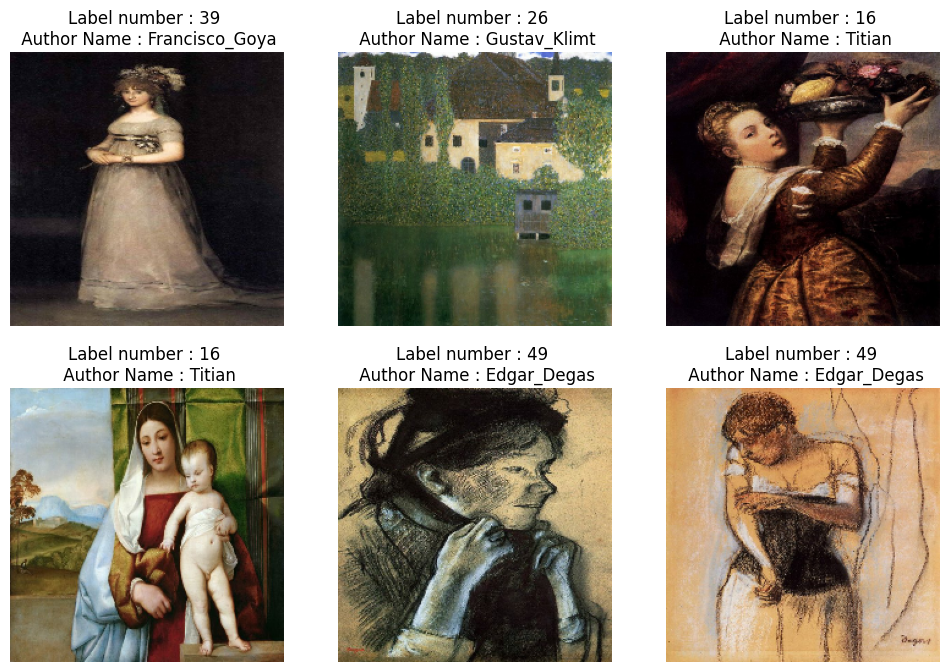

In [141]:
# 取出 Tensor 圖片來看看
plt.figure(figsize=(12, 8))
for index, (img, label) in enumerate(full_ds.take(6)):
    l = np.argmax(label.numpy())
    plt.subplot(2, 3, index + 1)
    plt.imshow(img)
    plt.title("Label number : {} \n Author Name : {}".format(l, rev_class_name[l]))
    plt.axis("off")

* 目標輸出

![](https://i.imgur.com/gvwxegB.png)

In [142]:
# 切割成 training data 與 validation data
train_len = int(0.8 * total_len)
val_len = total_len - train_len

train_ds = full_ds.take(train_len)
val_ds = full_ds.skip(train_len)

print("train size : ", train_len, " val size : ", val_len)

# 添加 batch
# todo
BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

train size :  6016  val size :  1504


In [143]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x, y = trainiter.next()
print("training image batch shape : ", x.shape)
print("training label batch shape : ", y.shape)

training image batch shape :  (32, 224, 224, 3)
training label batch shape :  (32, 50)


In [144]:
# from sklearn.utils import class_weight
# labels = np.argmax(onehot_labels, axis=1)
# class_weights = class_weight.compute_class_weight(
#     'balanced',
#     classes=np.unique(labels),
#     y=labels
# )

# class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# class_weights_dict = {class_label: weight for class_label, weight in zip(np.unique(labels), class_weights)}
# print(class_weights_dict)
def create_class_weights(artist_dataframe, artist_to_id):
    total_paintings = artist_dataframe['paintings'].sum()
    class_weights = {}

    for artist_name, artist_index in artist_to_id.items():
        num_paintings = artist_dataframe[artist_dataframe['name'] == artist_name]['paintings'].values[0]
        class_weight = total_paintings / (num_paintings * len(artist_to_id))
        class_weights[artist_index] = class_weight

    return class_weights

# 使用你的 artists DataFrame 和 make_author_dict 函數
author_to_id = make_author_dict()
class_weights = create_class_weights(artists, author_to_id)

print("Class Weights:", class_weights)




Class Weights: {0: 0.8707216494845361, 1: 1.3406349206349206, 2: 1.8768888888888888, 3: 1.1812587412587412, 4: 1.549724770642202, 5: 1.3196875, 6: 0.7067782426778243, 7: 1.1980141843971632, 8: 0.8985106382978724, 9: 1.4194957983193277, 10: 2.0854320987654322, 11: 0.8752331606217617, 12: 0.6522007722007722, 13: 1.941609195402299, 14: 0.9081720430107527, 15: 1.03, 16: 0.6624313725490196, 17: 1.7062626262626264, 18: 2.313972602739726, 19: 2.010952380952381, 20: 1.215251798561151, 21: 2.863050847457627, 22: 0.5431511254019292, 23: 1.2605970149253731, 24: 0.19261117445838086, 25: 1.656078431372549, 26: 1.4437606837606838, 27: 2.4131428571428573, 28: 0.9878362573099415, 29: 3.0712727272727274, 30: 0.5027380952380952, 31: 2.0854320987654322, 32: 5.449032258064516, 33: 1.8562637362637362, 34: 1.232992700729927, 35: 3.5940425531914895, 36: 0.515, 37: 7.038333333333333, 38: 0.38478359908883825, 39: 0.5804810996563574, 40: 1.4076666666666666, 41: 3.9283720930232557, 42: 1.9195454545454544, 43: 2.

## 4. 建立模型

發揮你的創意，建立模型。

請不要用已有的知名模型做 fine-tuning，**請自己手動建**。

In [145]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# 自訂你的 model
model = keras.Sequential([
    layers.Input(shape = input_shape),
    layers.experimental.preprocessing.RandomZoom(0.1),
    #layers.experimental.preprocessing.RandomTranslation(0.1,0.2),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.GlobalAveragePooling2D(),
    #layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom_4 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 conv2d_36 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 110, 110, 64)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 110, 110, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_37 (Conv2D)          (None, 108, 108, 128)    

## 5. 制定訓練計畫

把前處理完的資料輸入進去

In [146]:
# todo
from tensorflow.keras.optimizers import Adam
EPOCHS = 30
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, class_weight = class_weights)

Epoch 1/30
188/188 [==============================] - 91s 439ms/step - loss: 3.4007 - accuracy: 0.1114 - val_loss: 4.2116 - val_accuracy: 0.0047
Epoch 2/30
188/188 [==============================] - 88s 449ms/step - loss: 2.9863 - accuracy: 0.1815 - val_loss: 4.7850 - val_accuracy: 0.0047
Epoch 3/30
188/188 [==============================] - 91s 460ms/step - loss: 2.7913 - accuracy: 0.2183 - val_loss: 3.7696 - val_accuracy: 0.0758
Epoch 4/30
188/188 [==============================] - 91s 461ms/step - loss: 2.6120 - accuracy: 0.2502 - val_loss: 3.1899 - val_accuracy: 0.1456
Epoch 5/30
188/188 [==============================] - 91s 464ms/step - loss: 2.4962 - accuracy: 0.2683 - val_loss: 3.1331 - val_accuracy: 0.1928
Epoch 6/30
188/188 [==============================] - 91s 462ms/step - loss: 2.3981 - accuracy: 0.2960 - val_loss: 3.1249 - val_accuracy: 0.1802
Epoch 7/30
188/188 [==============================] - 92s 465ms/step - loss: 2.2853 - accuracy: 0.3158 - val_loss: 3.1477 - val_ac

## 6. 評估模型

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


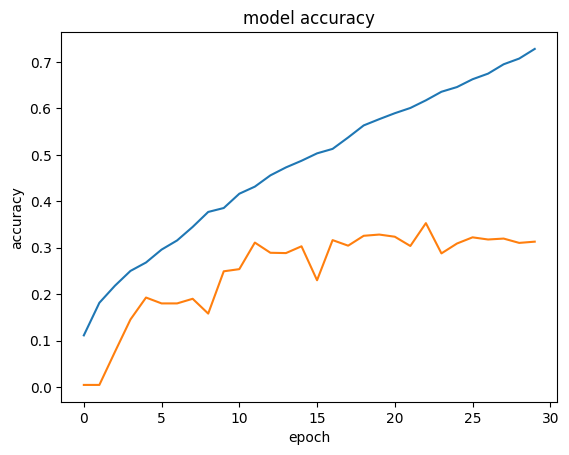

In [147]:
print(history.history.keys())

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

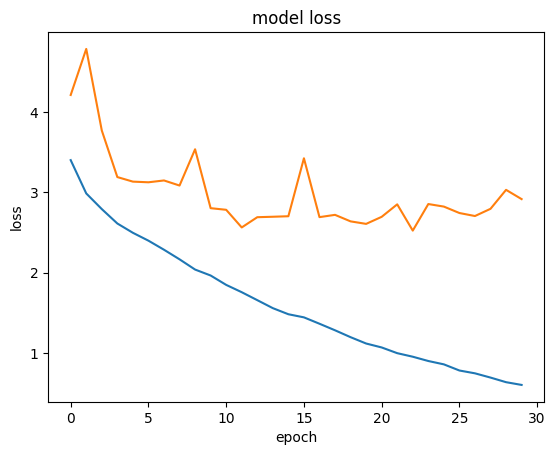

In [148]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")

plt.show()

In [149]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(BATCH_SIZE)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

27/27 [==============================] - 3s 82ms/step - loss: 3.0075 - accuracy: 0.2934
Test loss: 3.0075273513793945
Test accuracy: 0.2934131622314453


## 7. 做預測 (10分)
* 把前面讀取的圖片拿來丟入模型做預測
* 自己把一張現實中的圖片丟入 Model 做預測

In [150]:
def predict_author(img):
    # 擴展圖像維度
    img_expanded = np.expand_dims(img, axis=0)

    # 使用模型進行預測
    predictions = model.predict(img_expanded)

    # 找到最大概率對應的索引
    predicted_index = np.argmax(predictions)

    # 將索引轉換為畫家名字
    author_name = rev_class_name[predicted_index]
    return author_name



1/1 [==============================] - 0s 21ms/step


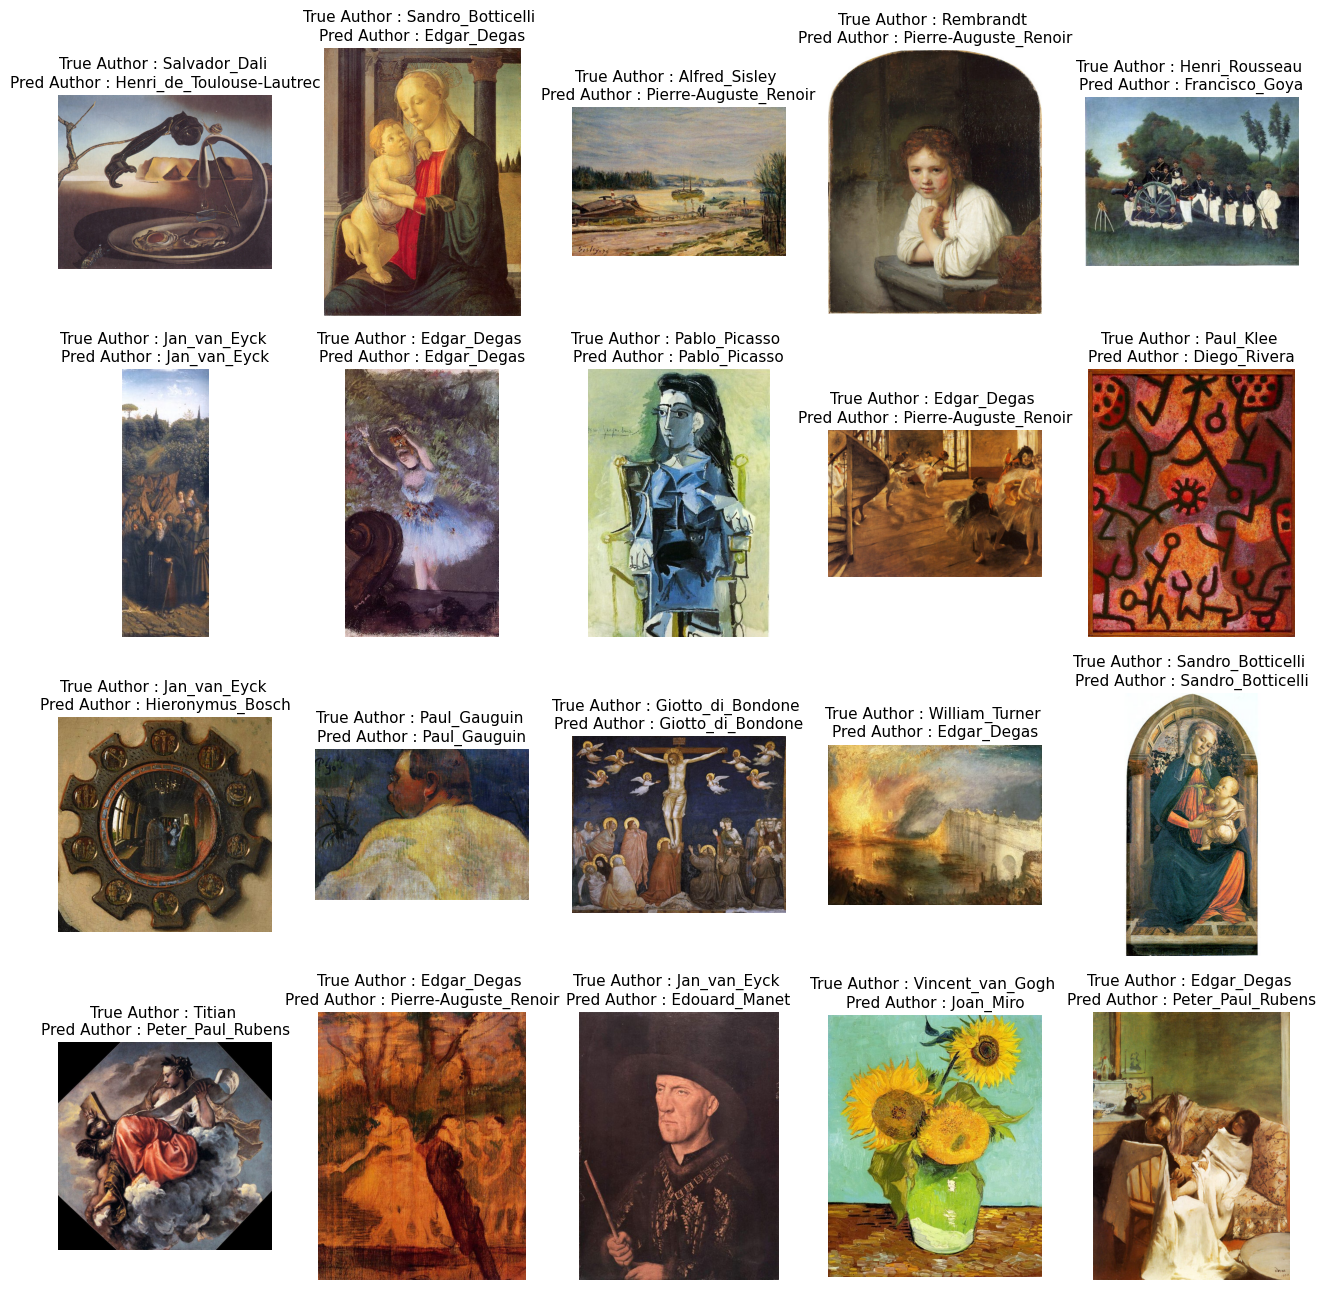

In [151]:
plt.figure(figsize=(16, 16))
for index, imgName in enumerate(show_imgs):
    img_path = train_dir + imgName
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(4, 5, index + 1)
    plt.axis("off")
    plt.imshow(img)
    img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    plt.title(
        "True Author : {} \nPred Author : {}".format(
            "_".join(imgName.split("_")[:-1]), predict_author(img)
        ),
        size=11,
    )
plt.show()

* 期望結果
![](https://i.imgur.com/ZEtd7yf.png)

* 自己上傳圖片來試試看模型的效果

In [152]:
from google.colab import files


def upload_img():
    uploaded = files.upload()
    img_name = list(uploaded.keys())[0]
    img = cv.imread(img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    return img


def eval():
    img = upload_img()
    plt.title("predict author : {}".format(predict_author(img)))
    plt.axis("off")
    plt.show()

Saving Michael-Jordan-1988.webp to Michael-Jordan-1988 (1).webp
1/1 [==============================] - 0s 22ms/step


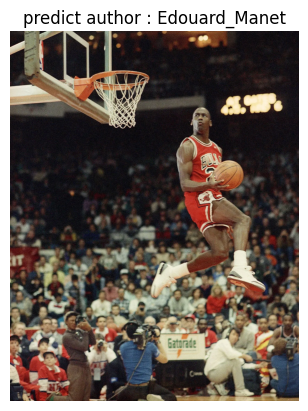

In [153]:
# 自己上傳一張圖片來試試看
# Demo 圖片來自:
# Interview with Cyberpunk 2077 "ponpon shit" producer Yuki Kawamura (https://block.fm/news/cyberpunk2077_uscracks_ENG)
eval()